### Эмбеддинги в NLP

В этом задании мы научимся работать с моделями для построения векторных представлений текста. Загрузим и потестируем предобученные модели, посмотрим, какие свойства и функции у них есть, обучим свою модель и с помощью нее улучшим качество кластеризации(и/или классификации) текстов.

Перед тем как приступать к выполнению задания не забудьте выполнить команду pip install -r <path_to_rep_requirements.txt> для того, чтобы в вашем виртуальном окружении были установлены правильные версии python пакетов.

In [4]:
import string
import warnings
import logging
import itertools

import nltk
import gensim
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import MiniBatchKMeans

In [5]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO)

In [6]:
%pylab inline

plt.style.use('default')
figsize(12, 9)

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

mpl.rcParams['font.family'] = 'Ubuntu'

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', weight='bold')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
 
font = {'family': 'Verdana',
        'weight': 'normal'}
mpl.rc('font', **font)

Populating the interactive namespace from numpy and matplotlib


Скачиваем rucorpora 15 с [диска](https://yadi.sk/d/fLRMFhm03Pbs98).
Либо выбираем предобученную модель с https://rusvectores.org/ru/models/. Выбор нужно обосновать.

In [7]:
path_to_ruscorpora = 'ruscorpora.model.bin'

#### Загрузим обученную на ruscorpora модель word2vec

In [ ]:
model_word2vec = gensim.models.KeyedVectors.load_word2vec_format(path_to_ruscorpora, binary=True)
model_word2vec.wv.vocab

#### Посмотрим, как с ней обращаться

Можно посмотреть наиболее похожие на конкретное слово слова. Попробуйте свойства векторов word2vec: и подумайте какие слова нужно послать на вход, чтобы получить на выходе слова "школа",  "машинное", "обучение".

In [6]:
model_word2vec.most_similar(positive=['корабль'],
                            negative=['парус'],
                            topn=3)

2019-04-21 11:05:14,710 : INFO : precomputing L2-norms of word weight vectors


[('судно', 0.4670174717903137),
 ('крейсер', 0.374319463968277),
 ('пароход', 0.33206045627593994)]

In [7]:
model_word2vec.most_similar(positive=['корабль', 'летать'],
                            negative=['плавать'],
                            topn=3)

[('самолет', 0.5802854299545288),
 ('судно', 0.533637523651123),
 ('дирижабль', 0.5083058476448059)]

In [8]:
model_word2vec.most_similar(positive=['шахтер'],
                            negative=['грязь'],
                            topn=3)

[('горняк', 0.3543156683444977),
 ('ударник', 0.336887001991272),
 ('металлург', 0.3220180869102478)]

In [9]:
model_word2vec.most_similar(positive=['учение', 'тьма'],
                            negative=['свет'],
                            topn=3)

[('мрак', 0.4193800687789917),
 ('догмат', 0.38442569971084595),
 ('философия', 0.3840946555137634)]

Еще есть функция, которая выводит лишнее слово в строке. Попробуйте придумать пример, с которым word2vec не справится.

In [10]:
model_word2vec.doesnt_match("коньяк компот водка пиво".split())

'компот'

In [11]:
model_word2vec.doesnt_match("лягушка трава яблоко свинья".split())

'трава'

In [12]:
model_word2vec.doesnt_match("самолет чайка страус стрекоза облако".split())

'самолет'

Функция, которая выводит сходство между словами.  С ее помощью можно понимать значение слова нефть.

In [13]:
print(model_word2vec.similarity('нефть', 'газ'))
print(model_word2vec.similarity('нефть', 'вода'))
print(model_word2vec.similarity('нефть', 'водка'))
print(model_word2vec.similarity('нефть', 'духи'))
print(model_word2vec.similarity('нефть', 'компот'))

0.40178457
0.24677068
0.08598832
0.029723397
0.014373137


Или смотреть, где в России больше нефти.

In [14]:
print(model_word2vec.similarity('нефть', 'чечня'))
print(model_word2vec.similarity('нефть', 'якутск'))
print(model_word2vec.similarity('нефть', 'москва'))
print(model_word2vec.similarity('нефть', 'саратов'))
print(model_word2vec.similarity('нефть', 'сибирь'))

0.10231814
0.037459407
0.0076551996
0.0043799113
0.08630519


### Пункт 0
Допишите своих интересных примеров, характеризующих word2vec, попробуйте обосновать полученные результаты.

In [15]:
model_word2vec.most_similar(positive=['женщина', 'король'], negative=['мужчина'], topn=2)
#<Ваш код>

[('принцесса', 0.5501185059547424), ('королева', 0.5400463938713074)]

In [16]:
model_word2vec.most_similar(positive=['вертолет'], negative=['полет'],  topn=2)

[('грузовик', 0.3279957175254822), ('танк', 0.3218498229980469)]

#### Теперь давайте обучим собственную модель
В качестве обучающего корпуса возьмем новости по 20 темам.

In [8]:
train_all = fetch_20newsgroups(subset='train')
print(train_all.target_names, " - 20 возможных тем")

dataset = fetch_20newsgroups(
    subset='train', 
    categories=['comp.sys.mac.hardware', 'soc.religion.christian', 'rec.sport.hockey'])

dataset.data[0].split()

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']  - 20 возможных тем


['From:',
 'erik@cheshire.oxy.edu',
 '(Erik',
 'Adams)',
 'Subject:',
 'HELP!!',
 'My',
 'Macintosh',
 '"luggable"',
 'has',
 'lines',
 'on',
 'its',
 'screen!',
 'Organization:',
 'Occidental',
 'College,',
 'Los',
 'Angeles,',
 'CA',
 '90041',
 'USA.',
 'Distribution:',
 'comp',
 'Lines:',
 '20',
 'Okay,',
 'I',
 "don't",
 'use',
 'it',
 'very',
 'much,',
 'but',
 'I',
 'would',
 'like',
 'for',
 'it',
 'to',
 'keep',
 'working',
 'correctly,',
 'at',
 'least',
 'as',
 'long',
 'as',
 'Apple',
 'continues',
 'to',
 'make',
 'System',
 'software',
 'that',
 'will',
 'run',
 'on',
 'it,',
 'if',
 'slowly',
 ':-)',
 'Here',
 'is',
 'the',
 'problem:',
 'When',
 'the',
 'screen',
 'is',
 'tilted',
 'too',
 'far',
 'back,',
 'vertical',
 'lines',
 'appear',
 'on',
 'the',
 'screen.',
 'They',
 'are',
 'every',
 '10',
 'pixels',
 'or',
 'so,',
 'and',
 'seem',
 'to',
 'be',
 'affected',
 'somewhat',
 'by',
 'opening',
 'windows',
 'and',
 'pulling',
 'down',
 'menus.',
 'It',
 'looks',
 't

### Пункт 1

Предобработаем эти новости. Выкинем цифры, знаки пунктуации, переведем в нижний регистр, разобьем на слова.

Нормализуйте слова, например с помощью модуля nltk (или используйте любой другой способ на ваш выбор).

In [9]:
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 
def normalize(raw_text):
    tokens = nltk.tokenize.word_tokenize(raw_text)
    words = []
    for word in tokens:
        if word.isalpha():
            words.append(word.lower()) 
    #words = [word for word in tokens if word.isalpha()]
    #words = [word.lower() for word in words]
    #stemming
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in words]
    
    #lemmatizing
    # Init the Wordnet Lemmatizer
    lemmatizer = WordNetLemmatizer()
    # Lemmatize Single Word
    lemmatized=[lemmatizer.lemmatize(word) for word in words]
    preprocessed_text = lemmatized
    return preprocessed_text

In [19]:
word='1'
word.isalpha()

False

In [10]:
nltk.download('punkt')
nltk.download('wordnet')
data_normalized = [normalize(news) for news in tqdm(dataset.data)]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pi.karasev\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pi.karasev\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


100%|██████████████████████████████████████████████████████████████████████████████| 1777/1777 [00:44<00:00, 50.05it/s]


Теперь обучающий корпус готов.

In [11]:
sentences = data_normalized
model = gensim.models.Word2Vec(sentences, min_count=1)

2019-04-22 20:31:01,239 : INFO : collecting all words and their counts
2019-04-22 20:31:01,242 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-04-22 20:31:01,523 : INFO : collected 19542 word types from a corpus of 455098 raw words and 1777 sentences
2019-04-22 20:31:01,528 : INFO : Loading a fresh vocabulary
2019-04-22 20:31:01,624 : INFO : effective_min_count=1 retains 19542 unique words (100% of original 19542, drops 0)
2019-04-22 20:31:01,626 : INFO : effective_min_count=1 leaves 455098 word corpus (100% of original 455098, drops 0)
2019-04-22 20:31:01,730 : INFO : deleting the raw counts dictionary of 19542 items
2019-04-22 20:31:01,739 : INFO : sample=0.001 downsamples 48 most-common words
2019-04-22 20:31:01,743 : INFO : downsampling leaves estimated 352238 word corpus (77.4% of prior 455098)
2019-04-22 20:31:01,839 : INFO : estimated required memory for 19542 words and 100 dimensions: 25404600 bytes
2019-04-22 20:31:01,842 : INFO : resetting laye

2019-04-22 20:36:04,338 : INFO : EPOCH 2 - PROGRESS: at 63.42% examples, 1694 words/s, in_qsize 5, out_qsize 0
2019-04-22 20:36:06,507 : INFO : EPOCH 2 - PROGRESS: at 65.11% examples, 1723 words/s, in_qsize 5, out_qsize 0
2019-04-22 20:36:08,293 : INFO : EPOCH 2 - PROGRESS: at 66.52% examples, 1734 words/s, in_qsize 6, out_qsize 0
2019-04-22 20:36:15,229 : INFO : EPOCH 2 - PROGRESS: at 67.53% examples, 1704 words/s, in_qsize 5, out_qsize 0
2019-04-22 20:36:17,941 : INFO : EPOCH 2 - PROGRESS: at 67.87% examples, 1730 words/s, in_qsize 6, out_qsize 0
2019-04-22 20:36:25,570 : INFO : EPOCH 2 - PROGRESS: at 72.76% examples, 1740 words/s, in_qsize 5, out_qsize 0
2019-04-22 20:36:28,179 : INFO : EPOCH 2 - PROGRESS: at 75.58% examples, 1760 words/s, in_qsize 5, out_qsize 0
2019-04-22 20:36:37,647 : INFO : EPOCH 2 - PROGRESS: at 80.98% examples, 1752 words/s, in_qsize 6, out_qsize 0
2019-04-22 20:36:40,267 : INFO : EPOCH 2 - PROGRESS: at 83.40% examples, 1770 words/s, in_qsize 5, out_qsize 0
2

2019-04-22 20:41:16,896 : INFO : EPOCH 4 - PROGRESS: at 33.65% examples, 1791 words/s, in_qsize 5, out_qsize 0
2019-04-22 20:41:23,732 : INFO : EPOCH 4 - PROGRESS: at 35.57% examples, 1727 words/s, in_qsize 5, out_qsize 0
2019-04-22 20:41:25,085 : INFO : EPOCH 4 - PROGRESS: at 37.37% examples, 1798 words/s, in_qsize 5, out_qsize 0
2019-04-22 20:41:28,314 : INFO : EPOCH 4 - PROGRESS: at 39.34% examples, 1819 words/s, in_qsize 5, out_qsize 0
2019-04-22 20:41:36,311 : INFO : EPOCH 4 - PROGRESS: at 41.76% examples, 1739 words/s, in_qsize 5, out_qsize 0
2019-04-22 20:41:39,657 : INFO : EPOCH 4 - PROGRESS: at 45.92% examples, 1842 words/s, in_qsize 5, out_qsize 0
2019-04-22 20:41:47,401 : INFO : EPOCH 4 - PROGRESS: at 48.17% examples, 1770 words/s, in_qsize 5, out_qsize 0
2019-04-22 20:41:48,590 : INFO : EPOCH 4 - PROGRESS: at 50.93% examples, 1826 words/s, in_qsize 5, out_qsize 0
2019-04-22 20:41:50,964 : INFO : EPOCH 4 - PROGRESS: at 53.24% examples, 1860 words/s, in_qsize 5, out_qsize 0
2

In [ ]:
model = gensim.models.Word2Vec(iter=1)  # Инициализируем модель.
model.build_vocab(sentences)  # Строим словарь.
model.train(sentences, total_examples=model.corpus_count, epochs=20)  # Тренируем модель.

Нарисуем слова из первой новости в новом векторном пространстве.

In [23]:
# Берем слова из первой новости, достаем соостветствующие векторы,
# выбрасываем слова, для которых векторов нет. 
# Подумайте - как так могло получится, что нет векторов?
labels = []
embeddings = []
data_to_tsne = [item for sublist in data_normalized[:30] for item in sublist]

for x in list(set(data_to_tsne)):
    try:
        embeddings.append(model[x])
        labels.append(x)
    except KeyError:
        continue

In [24]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
    plt.show()
    plt.savefig(filename)
    

### Пункт 2
Переведите многомерные векторы в двумерные (можно использовать TSNE, PCA, другие методы сокращения размерности), выберите часть слов для отрисовки. Как параметры и методы отрисовки влияют на полученный график? Как это можно обьяснить?

In [25]:
from sklearn import manifold
def embeddings_2d(embeddings):
    tsne = manifold.TSNE(n_components = 2, init = 'pca', random_state = 0)
    data_2d_tsne = tsne.fit_transform(embeddings)
    return data_2d_tsne

In [26]:
num_words_to_draw = 1000
low_dim_vectors = embeddings_2d(embeddings)
print(len(embeddings))
len(model.wv.vocab)

1368


6507

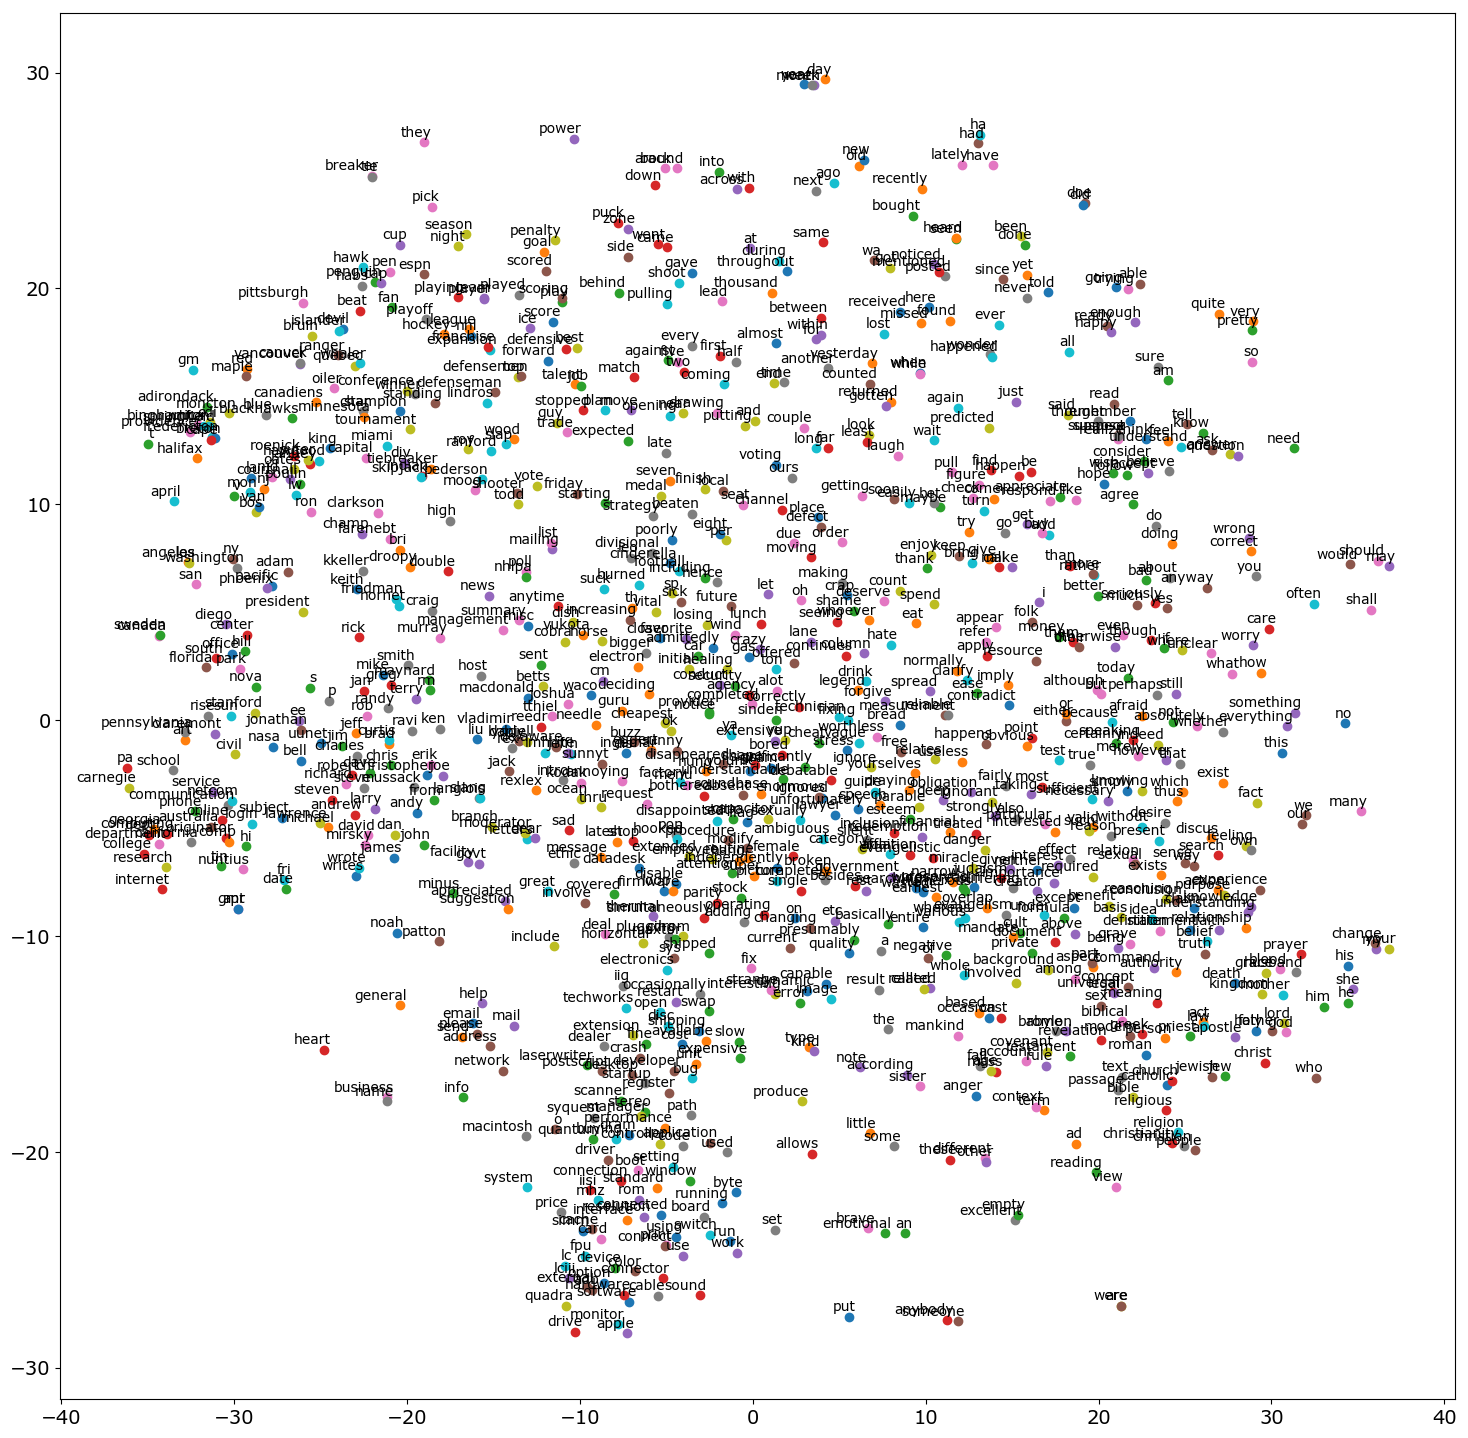

<Figure size 1200x900 with 0 Axes>

In [27]:
# Рисуем только первые 1000 слов.
labels_to_draw = [labels[i] for i in range(num_words_to_draw)]
a = plot_with_labels(low_dim_vectors, labels_to_draw)

### Пункт 3
Проделайте аналогичную отрисовку и сжатие векторов для предобученной модели (для этого скачайте бинарник по этой [ссылке](https://code.google.com/archive/p/word2vec/) (файл GoogleNews-vectors-negative300) по аналогии с тем, как мы работали с русским корпусом. Сравните результаты.

2019-04-21 12:20:19,380 : INFO : loading projection weights from GoogleNews-vectors-negative300.bin
2019-04-21 12:20:19,384 : WARNING : this function is deprecated, use smart_open.open instead
2019-04-21 12:24:44,245 : INFO : loaded (3000000, 300) matrix from GoogleNews-vectors-negative300.bin


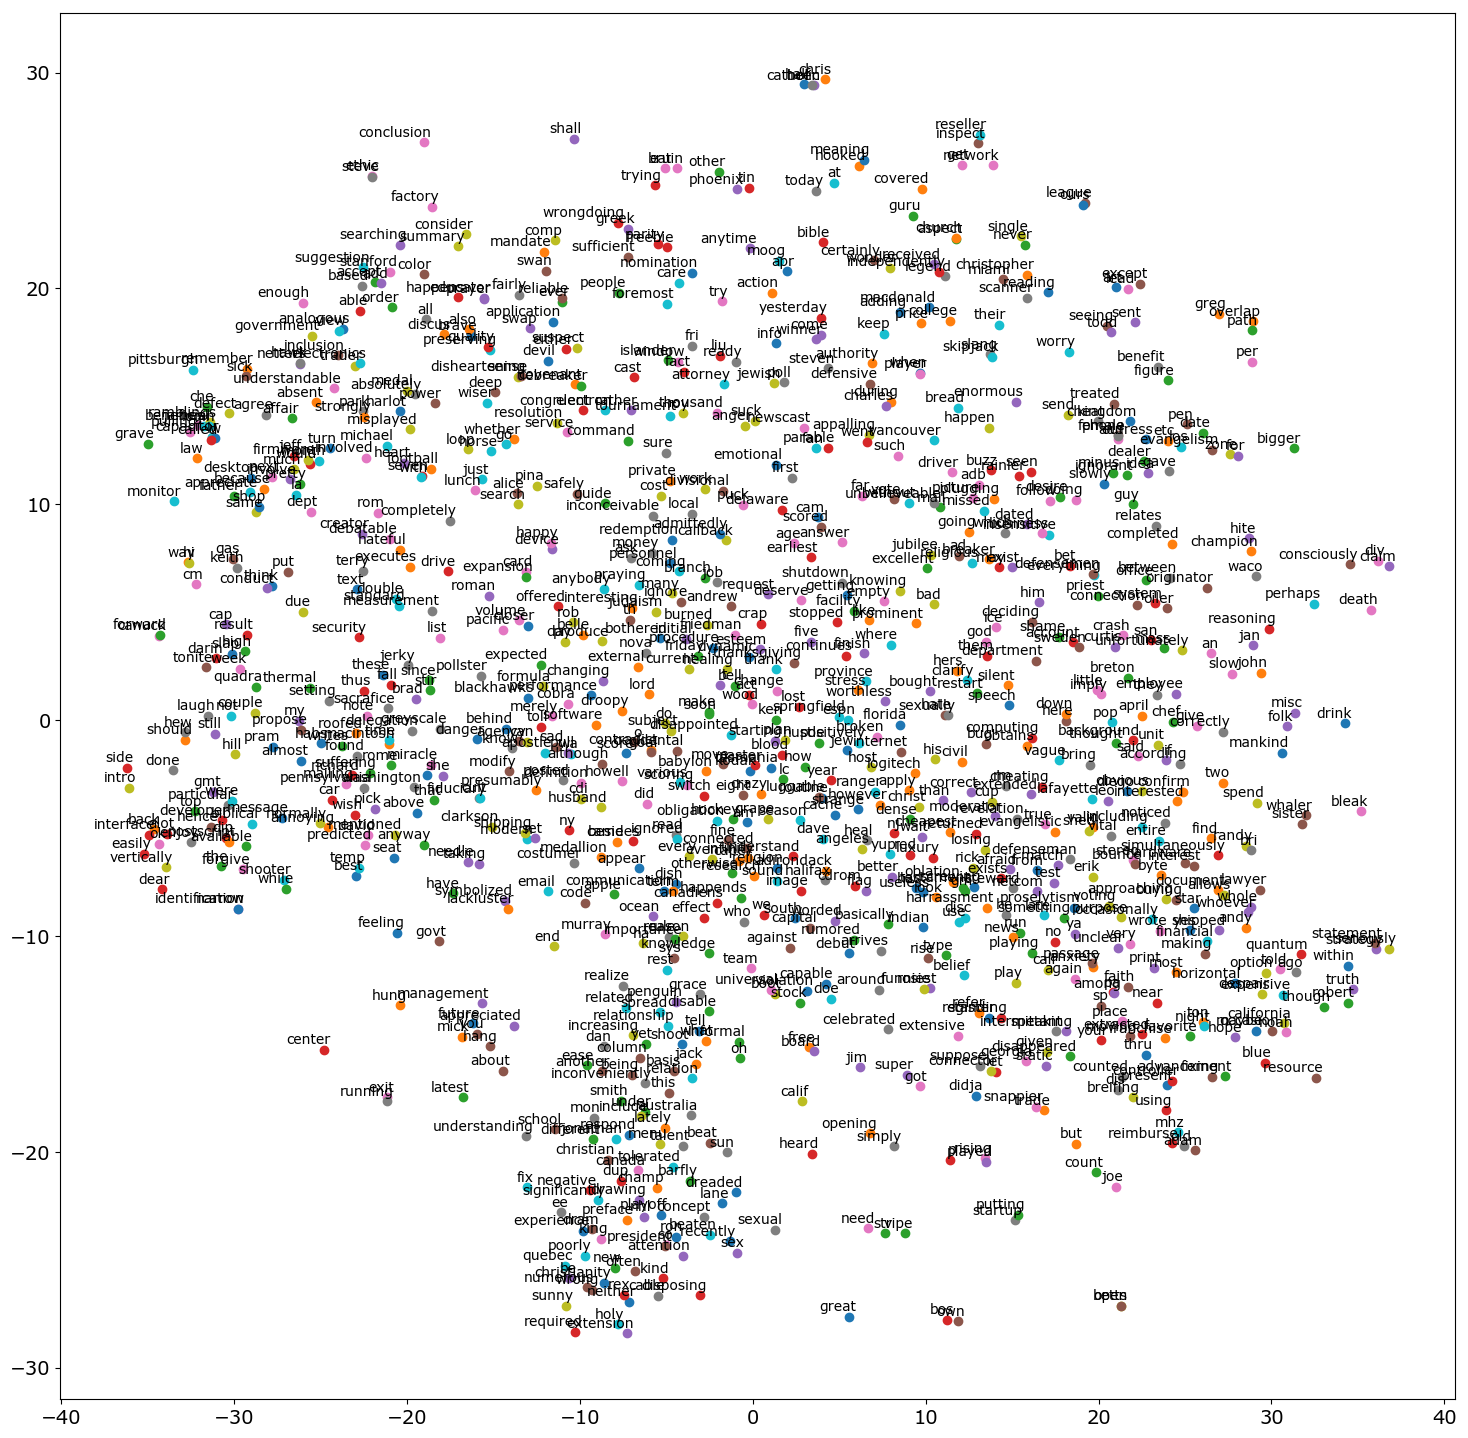

<Figure size 1200x900 with 0 Axes>

In [28]:
path_to_GoogleNews = 'GoogleNews-vectors-negative300.bin'
model_GoogleNews = gensim.models.KeyedVectors.load_word2vec_format(path_to_GoogleNews, binary=True)
#model_word2vec.wv.vocab
labels = []
embeddings = []
data_to_tsne = [item for sublist in data_normalized[:30] for item in sublist]

for x in list(set(data_to_tsne)):
    try:
        embeddings.append(model_GoogleNews[x])
        labels.append(x)
    except KeyError:
        continue
labels_to_draw = [labels[i] for i in range(num_words_to_draw)]
a = plot_with_labels(low_dim_vectors, labels_to_draw)


### Попробуем с помощью нашей модели улучшить качество кластеризации текстов
Если вы не знаете, что такое кластеризация - почитать об этом можно по [ссылке](http://scikit-learn.org/stable/modules/clustering.html).

Если вам все равно кажется, что это сложно, и вы чувствуете себя более уверено в задаче классификации - вместо задачи кластеризации можно рассматривать задачу классификации - тогда вместо функции quality используйте roc-auc из библиотеки scikit-learn, все остальные шаги предобработки и измерения признаков аналогичны.

Измерять качество кластеризации будем следующим образом - измерим количество правильных попаданий категории в кластеры.

In [29]:
def quality(preds, target):
    permutations = list(itertools.permutations([0, 1, 2]))
    scores = []
    for a, b, c in permutations:
        mapping = {2 : a, 1: b, 0: c}
        mapped_preds = [mapping[pred] for pred in preds]
        scores.append(float(sum(mapped_preds != target)) / len(target))
    return 1 - min(scores)

### Пункт 4
Кластеризуйте датасет с заданием признаков с помощью one hot encoding - посмотрите на результат.

In [3]:
#from sklearn.cluster import DBSCAN
#clustering = DBSCAN(eps=3, min_samples=2).fit(model[x].reshape(-1,1))

#test_all = fetch_20newsgroups(subset='test')
#print(test_all.target_names, " - 20 возможных тем")
testset = fetch_20newsgroups(
    subset='test', 
    categories=['comp.sys.mac.hardware', 'soc.religion.christian', 'rec.sport.hockey'])
print(dataset.data[10])
print(dataset.target[10])


NameError: name 'fetch_20newsgroups' is not defined

In [33]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
#encoded = onehot_encoder.fit_transform(dataset.data)
#encoded= [average_feature_vector(sent, onehot_encoder.fit_transform)
encoded=[]
corpus=set({})
for words in data_normalized:
    for word in words:
        corpus.add(word)
corpus=list(corpus)
print(corpus[6])
print(len(corpus))
# corpus1=set(corpus)
# print(len(corpus1))
vector=onehot_encoder.fit_transform(np.array(corpus[:10000]).reshape(-1, 1))
print(vector)
encoded= dict(zip(corpus[:10000], vector))
print(encoded['ad'])

chariot
19542
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 0. 0. ... 0. 0. 0.]


In [35]:
print(encoded['monitor'])

[0. 0. 0. ... 0. 0. 0.]


In [36]:
def average_feature_vector0(words, model):
    vector=np.zeros(100)
    for word in words:
        try:
            vector+=model[word]
            print(vector)
        except:
            print('no vector')
    average_feature_vector = vector/len(words)
    return average_feature_vector

In [ ]:
print(type(data_normalized))
data_normalized_vectors=[]
for sent in data_normalized:
    #print(type(sent))
    data_normalized_vectors.append(average_feature_vector0(sent, encoded))
#data_normalized_vectors = [average_feature_vector(sent, encoded) for sent in data_normalized]

In [38]:
tsne_vec = manifold.TSNE(n_components = 3, init = 'pca', random_state = 0)
low_dim_vectors = tsne_vec.fit_transform(data_normalized_vectors)
preds = MiniBatchKMeans(n_clusters=3).fit_predict(low_dim_vectors)
quality(preds, dataset.target)

### Пункт 5
Далее кластеризуем тексты на векторах, полученных из модели, которую мы сами обучили.

Напишем функцию, которая делает из предложения вектор - усредняет векторы всех слов в этом предложении. Если слова нет в словаре, то вместо вектора этого слова используется нулевой вектор.

In [39]:
model['music']

In [40]:
def average_feature_vector(words, model):
    vector=np.zeros(100)
    for word in words:
        try:
            vector+=np.array(model[word])
            print(vector)
        except:
            print('no vector')
    average_feature_vector = vector/len(words)
    return average_feature_vector


Применим функцию к нашим данным (уже нормализованным функцией normalize).

In [41]:
average_feature_vector(['music', 'can'], model)

In [ ]:
data_normalized_vectors = [average_feature_vector(sent, model)
                           for sent in data_normalized]   

Сожмем массив признаков с помощью TSNE до нескольких компонент (попробуйте поварьировать число компонент).

In [43]:
tsne_vec = manifold.TSNE(n_components = 3, init = 'pca', random_state = 0)
low_dim_vectors = tsne_vec.fit_transform(data_normalized_vectors)

Примените алгоритм кластеризации (например, K-means).

In [44]:
preds = MiniBatchKMeans(n_clusters=3).fit_predict(low_dim_vectors)
quality(preds, dataset.target)

0.9622960045019696

### Пункт 6

Кластеризуйте тексты на векторах, полученных из предобученной модели. Какой результат получился лучше? Почему?

In [45]:
average_feature_vector(['music', 'can'], model_GoogleNews)

no vector
no vector


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
data_normalized_vectors_google = [average_feature_vector(sent, model_GoogleNews)
                           for sent in sentences]
tsne_vec = manifold.TSNE(n_components = 3, init = 'pca', random_state = 0)
low_dim_vectors = tsne_vec.fit_transform(data_normalized_vectors_google)

In [ ]:
preds = MiniBatchKMeans(n_clusters=3).fit_predict(low_dim_vectors)
quality(preds, dataset.target)

### Пункт 7

Попробуйте получить аналогичные векторы и провести исследование на них с помощью fastq - [неплохое введение](https://www.analyticsvidhya.com/blog/2017/07/word-representations-text-classification-using-fasttext-nlp-facebook/).

In [68]:
#from pyfasttext import FastTextfasttext
#import fastText
#fast_text_model = fastText.load_model('wiki-news-300d-1M.vec')
#model.predict_proba(["Bonjour, Habr!"], 3)
#fasttext supervised #-input sentences -output model

In [12]:
from gensim.models import FastText
fast_model = FastText(sentences, min_count=1)  # instantiate

fast_model.build_vocab(sentences)
fast_model.train(sentences,  total_examples=model.corpus_count, epochs=20)

2019-04-22 20:46:09,890 : INFO : resetting layer weights
2019-04-22 20:46:10,434 : INFO : collecting all words and their counts
2019-04-22 20:46:10,444 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-04-22 20:46:10,695 : INFO : collected 19542 word types from a corpus of 455098 raw words and 1777 sentences
2019-04-22 20:46:10,697 : INFO : Loading a fresh vocabulary
2019-04-22 20:46:10,946 : INFO : effective_min_count=1 retains 19542 unique words (100% of original 19542, drops 0)
2019-04-22 20:46:10,950 : INFO : effective_min_count=1 leaves 455098 word corpus (100% of original 455098, drops 0)
2019-04-22 20:46:11,164 : INFO : deleting the raw counts dictionary of 19542 items
2019-04-22 20:46:11,169 : INFO : sample=0.001 downsamples 48 most-common words
2019-04-22 20:46:11,173 : INFO : downsampling leaves estimated 352238 word corpus (77.4% of prior 455098)
2019-04-22 20:46:34,407 : INFO : estimated required memory for 19542 words, 125300 buckets and 4 dim

2019-04-22 20:55:29,491 : INFO : EPOCH 2 - PROGRESS: at 35.57% examples, 864 words/s, in_qsize 6, out_qsize 0
2019-04-22 20:55:35,322 : INFO : EPOCH 2 - PROGRESS: at 37.37% examples, 880 words/s, in_qsize 5, out_qsize 0
2019-04-22 20:55:48,308 : INFO : EPOCH 2 - PROGRESS: at 39.34% examples, 856 words/s, in_qsize 5, out_qsize 0
2019-04-22 20:55:53,583 : INFO : EPOCH 2 - PROGRESS: at 41.76% examples, 876 words/s, in_qsize 5, out_qsize 0
2019-04-22 20:55:57,280 : INFO : EPOCH 2 - PROGRESS: at 43.67% examples, 900 words/s, in_qsize 5, out_qsize 0
2019-04-22 20:56:08,919 : INFO : EPOCH 2 - PROGRESS: at 45.92% examples, 884 words/s, in_qsize 5, out_qsize 0
2019-04-22 20:56:16,478 : INFO : EPOCH 2 - PROGRESS: at 48.17% examples, 887 words/s, in_qsize 6, out_qsize 0
2019-04-22 20:56:21,599 : INFO : EPOCH 2 - PROGRESS: at 50.93% examples, 903 words/s, in_qsize 5, out_qsize 0
2019-04-22 20:56:35,223 : INFO : EPOCH 2 - PROGRESS: at 53.24% examples, 881 words/s, in_qsize 5, out_qsize 0
2019-04-22

2019-04-22 21:04:42,756 : INFO : EPOCH 3 - PROGRESS: at 83.40% examples, 944 words/s, in_qsize 5, out_qsize 0
2019-04-22 21:04:45,097 : INFO : EPOCH 3 - PROGRESS: at 85.42% examples, 961 words/s, in_qsize 6, out_qsize 0
2019-04-22 21:04:56,050 : INFO : EPOCH 3 - PROGRESS: at 87.84% examples, 953 words/s, in_qsize 6, out_qsize 0
2019-04-22 21:05:05,794 : INFO : EPOCH 3 - PROGRESS: at 90.38% examples, 949 words/s, in_qsize 5, out_qsize 0
2019-04-22 21:05:09,587 : INFO : EPOCH 3 - PROGRESS: at 92.29% examples, 960 words/s, in_qsize 4, out_qsize 0
2019-04-22 21:05:19,121 : INFO : EPOCH 3 - PROGRESS: at 94.77% examples, 955 words/s, in_qsize 3, out_qsize 0
2019-04-22 21:05:27,609 : INFO : EPOCH 3 - PROGRESS: at 96.68% examples, 953 words/s, in_qsize 2, out_qsize 1
2019-04-22 21:05:27,612 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-22 21:05:30,305 : INFO : EPOCH 3 - PROGRESS: at 97.75% examples, 957 words/s, in_qsize 1, out_qsize 1
2019-04-22 21:05:30,307 : INF

2019-04-22 21:13:53,916 : INFO : EPOCH 5 - PROGRESS: at 45.92% examples, 1030 words/s, in_qsize 5, out_qsize 0
2019-04-22 21:14:10,335 : INFO : EPOCH 5 - PROGRESS: at 48.17% examples, 976 words/s, in_qsize 6, out_qsize 0
2019-04-22 21:14:14,782 : INFO : EPOCH 5 - PROGRESS: at 50.93% examples, 993 words/s, in_qsize 6, out_qsize 0
2019-04-22 21:14:17,062 : INFO : EPOCH 5 - PROGRESS: at 53.24% examples, 1024 words/s, in_qsize 5, out_qsize 0
2019-04-22 21:14:29,592 : INFO : EPOCH 5 - PROGRESS: at 54.98% examples, 996 words/s, in_qsize 6, out_qsize 0
2019-04-22 21:14:36,510 : INFO : EPOCH 5 - PROGRESS: at 57.40% examples, 998 words/s, in_qsize 5, out_qsize 0
2019-04-22 21:14:40,576 : INFO : EPOCH 5 - PROGRESS: at 59.65% examples, 1017 words/s, in_qsize 6, out_qsize 0
2019-04-22 21:14:47,070 : INFO : EPOCH 5 - PROGRESS: at 61.79% examples, 1018 words/s, in_qsize 6, out_qsize 0
2019-04-22 21:14:55,313 : INFO : EPOCH 5 - PROGRESS: at 62.58% examples, 994 words/s, in_qsize 5, out_qsize 0
2019-0

2019-04-22 21:22:46,728 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-22 21:22:49,127 : INFO : EPOCH 6 - PROGRESS: at 100.00% examples, 992 words/s, in_qsize 0, out_qsize 1
2019-04-22 21:22:49,129 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-22 21:22:49,132 : INFO : EPOCH - 6 : training on 455098 raw words (352451 effective words) took 355.4s, 992 effective words/s
2019-04-22 21:23:04,108 : INFO : EPOCH 7 - PROGRESS: at 1.97% examples, 388 words/s, in_qsize 6, out_qsize 0
2019-04-22 21:23:10,591 : INFO : EPOCH 7 - PROGRESS: at 4.67% examples, 610 words/s, in_qsize 6, out_qsize 0
2019-04-22 21:23:13,274 : INFO : EPOCH 7 - PROGRESS: at 5.97% examples, 855 words/s, in_qsize 6, out_qsize 0
2019-04-22 21:23:23,281 : INFO : EPOCH 7 - PROGRESS: at 8.10% examples, 809 words/s, in_qsize 6, out_qsize 0
2019-04-22 21:23:33,706 : INFO : EPOCH 7 - PROGRESS: at 9.96% examples, 791 words/s, in_qsize 5, out_qsize 0
2019-04-22 21:23:35,125 : IN

2019-04-22 21:32:06,935 : INFO : EPOCH 8 - PROGRESS: at 54.98% examples, 865 words/s, in_qsize 5, out_qsize 0
2019-04-22 21:32:11,295 : INFO : EPOCH 8 - PROGRESS: at 57.40% examples, 880 words/s, in_qsize 5, out_qsize 0
2019-04-22 21:32:17,569 : INFO : EPOCH 8 - PROGRESS: at 59.65% examples, 890 words/s, in_qsize 6, out_qsize 0
2019-04-22 21:32:26,351 : INFO : EPOCH 8 - PROGRESS: at 61.79% examples, 886 words/s, in_qsize 6, out_qsize 0
2019-04-22 21:32:32,574 : INFO : EPOCH 8 - PROGRESS: at 63.42% examples, 893 words/s, in_qsize 6, out_qsize 0
2019-04-22 21:32:35,564 : INFO : EPOCH 8 - PROGRESS: at 64.21% examples, 895 words/s, in_qsize 5, out_qsize 0
2019-04-22 21:32:37,651 : INFO : EPOCH 8 - PROGRESS: at 65.90% examples, 917 words/s, in_qsize 6, out_qsize 0
2019-04-22 21:32:39,778 : INFO : EPOCH 8 - PROGRESS: at 66.52% examples, 915 words/s, in_qsize 5, out_qsize 0
2019-04-22 21:32:55,633 : INFO : EPOCH 8 - PROGRESS: at 67.53% examples, 890 words/s, in_qsize 5, out_qsize 0
2019-04-22

2019-04-22 21:40:56,866 : INFO : EPOCH 10 - PROGRESS: at 4.67% examples, 526 words/s, in_qsize 5, out_qsize 0
2019-04-22 21:41:01,549 : INFO : EPOCH 10 - PROGRESS: at 5.97% examples, 697 words/s, in_qsize 5, out_qsize 0
2019-04-22 21:41:14,250 : INFO : EPOCH 10 - PROGRESS: at 8.10% examples, 652 words/s, in_qsize 6, out_qsize 0
2019-04-22 21:41:17,208 : INFO : EPOCH 10 - PROGRESS: at 9.96% examples, 779 words/s, in_qsize 5, out_qsize 0
2019-04-22 21:41:22,866 : INFO : EPOCH 10 - PROGRESS: at 11.25% examples, 839 words/s, in_qsize 6, out_qsize 0
2019-04-22 21:41:35,537 : INFO : EPOCH 10 - PROGRESS: at 13.45% examples, 791 words/s, in_qsize 5, out_qsize 0
2019-04-22 21:41:36,574 : INFO : EPOCH 10 - PROGRESS: at 15.64% examples, 896 words/s, in_qsize 5, out_qsize 0
2019-04-22 21:41:45,777 : INFO : EPOCH 10 - PROGRESS: at 17.84% examples, 885 words/s, in_qsize 5, out_qsize 0
2019-04-22 21:41:54,139 : INFO : EPOCH 10 - PROGRESS: at 19.92% examples, 875 words/s, in_qsize 5, out_qsize 0
2019-

2019-04-22 23:37:11,620 : INFO : EPOCH 11 - PROGRESS: at 59.65% examples, 31 words/s, in_qsize 6, out_qsize 0
2019-04-22 23:37:23,280 : INFO : EPOCH 11 - PROGRESS: at 61.79% examples, 32 words/s, in_qsize 5, out_qsize 0
2019-04-22 23:37:27,936 : INFO : EPOCH 11 - PROGRESS: at 63.42% examples, 33 words/s, in_qsize 5, out_qsize 0
2019-04-22 23:37:31,404 : INFO : EPOCH 11 - PROGRESS: at 64.21% examples, 34 words/s, in_qsize 6, out_qsize 0
2019-04-22 23:37:32,708 : INFO : EPOCH 11 - PROGRESS: at 65.90% examples, 35 words/s, in_qsize 5, out_qsize 0
2019-04-22 23:37:35,151 : INFO : EPOCH 11 - PROGRESS: at 66.52% examples, 35 words/s, in_qsize 5, out_qsize 0
2019-04-22 23:37:51,207 : INFO : EPOCH 11 - PROGRESS: at 67.53% examples, 36 words/s, in_qsize 5, out_qsize 0
2019-04-22 23:37:54,017 : INFO : EPOCH 11 - PROGRESS: at 69.95% examples, 37 words/s, in_qsize 6, out_qsize 0
2019-04-22 23:37:58,395 : INFO : EPOCH 11 - PROGRESS: at 70.29% examples, 38 words/s, in_qsize 5, out_qsize 0
2019-04-22

2019-04-22 23:45:44,732 : INFO : EPOCH 13 - PROGRESS: at 4.67% examples, 590 words/s, in_qsize 5, out_qsize 0
2019-04-22 23:45:48,908 : INFO : EPOCH 13 - PROGRESS: at 5.97% examples, 784 words/s, in_qsize 6, out_qsize 0
2019-04-22 23:46:06,043 : INFO : EPOCH 13 - PROGRESS: at 8.10% examples, 634 words/s, in_qsize 5, out_qsize 0
2019-04-22 23:46:09,271 : INFO : EPOCH 13 - PROGRESS: at 9.96% examples, 754 words/s, in_qsize 5, out_qsize 0
2019-04-22 23:46:12,141 : INFO : EPOCH 13 - PROGRESS: at 11.25% examples, 861 words/s, in_qsize 5, out_qsize 0
2019-04-22 23:46:28,364 : INFO : EPOCH 13 - PROGRESS: at 13.45% examples, 763 words/s, in_qsize 5, out_qsize 0
2019-04-22 23:46:29,832 : INFO : EPOCH 13 - PROGRESS: at 15.64% examples, 860 words/s, in_qsize 5, out_qsize 0
2019-04-22 23:46:36,817 : INFO : EPOCH 13 - PROGRESS: at 17.84% examples, 879 words/s, in_qsize 6, out_qsize 0
2019-04-22 23:46:50,249 : INFO : EPOCH 13 - PROGRESS: at 19.92% examples, 819 words/s, in_qsize 5, out_qsize 0
2019-

2019-04-22 23:55:23,000 : INFO : EPOCH 14 - PROGRESS: at 61.79% examples, 900 words/s, in_qsize 5, out_qsize 0
2019-04-22 23:55:25,788 : INFO : EPOCH 14 - PROGRESS: at 63.42% examples, 919 words/s, in_qsize 6, out_qsize 0
2019-04-22 23:55:31,122 : INFO : EPOCH 14 - PROGRESS: at 65.11% examples, 930 words/s, in_qsize 5, out_qsize 0
2019-04-22 23:55:37,037 : INFO : EPOCH 14 - PROGRESS: at 65.90% examples, 921 words/s, in_qsize 5, out_qsize 0
2019-04-22 23:55:57,462 : INFO : EPOCH 14 - PROGRESS: at 67.53% examples, 885 words/s, in_qsize 5, out_qsize 0
2019-04-22 23:56:01,593 : INFO : EPOCH 14 - PROGRESS: at 69.95% examples, 899 words/s, in_qsize 6, out_qsize 0
2019-04-22 23:56:10,708 : INFO : EPOCH 14 - PROGRESS: at 70.29% examples, 899 words/s, in_qsize 6, out_qsize 0
2019-04-22 23:56:27,007 : INFO : EPOCH 14 - PROGRESS: at 72.76% examples, 875 words/s, in_qsize 6, out_qsize 0
2019-04-22 23:56:28,526 : INFO : EPOCH 14 - PROGRESS: at 75.58% examples, 896 words/s, in_qsize 6, out_qsize 0
2

2019-04-23 00:06:19,226 : INFO : EPOCH 16 - PROGRESS: at 8.10% examples, 490 words/s, in_qsize 6, out_qsize 0
2019-04-23 00:06:31,294 : INFO : EPOCH 16 - PROGRESS: at 9.96% examples, 515 words/s, in_qsize 6, out_qsize 0
2019-04-23 00:06:33,257 : INFO : EPOCH 16 - PROGRESS: at 11.25% examples, 608 words/s, in_qsize 6, out_qsize 0
2019-04-23 00:07:00,729 : INFO : EPOCH 16 - PROGRESS: at 13.45% examples, 515 words/s, in_qsize 5, out_qsize 0
2019-04-23 00:07:13,518 : INFO : EPOCH 16 - PROGRESS: at 15.64% examples, 524 words/s, in_qsize 5, out_qsize 0
2019-04-23 00:07:17,835 : INFO : EPOCH 16 - PROGRESS: at 17.84% examples, 569 words/s, in_qsize 6, out_qsize 0
2019-04-23 00:07:32,600 : INFO : EPOCH 16 - PROGRESS: at 19.92% examples, 555 words/s, in_qsize 6, out_qsize 0
2019-04-23 00:07:48,965 : INFO : EPOCH 16 - PROGRESS: at 21.50% examples, 545 words/s, in_qsize 6, out_qsize 0
2019-04-23 00:07:52,327 : INFO : EPOCH 16 - PROGRESS: at 23.52% examples, 582 words/s, in_qsize 5, out_qsize 0
201

2019-04-23 00:19:26,741 : INFO : EPOCH 17 - PROGRESS: at 54.98% examples, 644 words/s, in_qsize 5, out_qsize 0
2019-04-23 00:19:30,301 : INFO : EPOCH 17 - PROGRESS: at 57.40% examples, 661 words/s, in_qsize 6, out_qsize 0
2019-04-23 00:19:39,772 : INFO : EPOCH 17 - PROGRESS: at 59.65% examples, 666 words/s, in_qsize 5, out_qsize 0
2019-04-23 00:19:52,984 : INFO : EPOCH 17 - PROGRESS: at 61.79% examples, 660 words/s, in_qsize 5, out_qsize 0
2019-04-23 00:19:58,427 : INFO : EPOCH 17 - PROGRESS: at 63.42% examples, 671 words/s, in_qsize 5, out_qsize 0
2019-04-23 00:20:04,611 : INFO : EPOCH 17 - PROGRESS: at 64.21% examples, 668 words/s, in_qsize 5, out_qsize 0
2019-04-23 00:20:07,181 : INFO : EPOCH 17 - PROGRESS: at 65.90% examples, 685 words/s, in_qsize 6, out_qsize 0
2019-04-23 00:20:09,892 : INFO : EPOCH 17 - PROGRESS: at 66.52% examples, 684 words/s, in_qsize 5, out_qsize 0
2019-04-23 00:20:28,076 : INFO : EPOCH 17 - PROGRESS: at 67.53% examples, 671 words/s, in_qsize 5, out_qsize 0
2

2019-04-23 00:30:45,020 : INFO : EPOCH 19 - PROGRESS: at 5.97% examples, 585 words/s, in_qsize 5, out_qsize 0
2019-04-23 00:31:06,085 : INFO : EPOCH 19 - PROGRESS: at 8.10% examples, 490 words/s, in_qsize 5, out_qsize 0
2019-04-23 00:31:15,676 : INFO : EPOCH 19 - PROGRESS: at 9.96% examples, 535 words/s, in_qsize 6, out_qsize 0
2019-04-23 00:31:16,972 : INFO : EPOCH 19 - PROGRESS: at 11.25% examples, 635 words/s, in_qsize 6, out_qsize 0
2019-04-23 00:31:41,656 : INFO : EPOCH 19 - PROGRESS: at 13.45% examples, 547 words/s, in_qsize 6, out_qsize 0
2019-04-23 00:31:49,898 : INFO : EPOCH 19 - PROGRESS: at 15.64% examples, 577 words/s, in_qsize 6, out_qsize 0
2019-04-23 00:31:52,186 : INFO : EPOCH 19 - PROGRESS: at 17.84% examples, 637 words/s, in_qsize 6, out_qsize 0
2019-04-23 00:32:06,170 : INFO : EPOCH 19 - PROGRESS: at 19.92% examples, 617 words/s, in_qsize 6, out_qsize 0
2019-04-23 00:32:18,256 : INFO : EPOCH 19 - PROGRESS: at 21.50% examples, 617 words/s, in_qsize 5, out_qsize 0
2019

2019-04-23 00:43:05,041 : INFO : EPOCH 20 - PROGRESS: at 61.79% examples, 769 words/s, in_qsize 5, out_qsize 0
2019-04-23 00:43:10,070 : INFO : EPOCH 20 - PROGRESS: at 63.42% examples, 781 words/s, in_qsize 6, out_qsize 0
2019-04-23 00:43:19,189 : INFO : EPOCH 20 - PROGRESS: at 64.21% examples, 768 words/s, in_qsize 6, out_qsize 0
2019-04-23 00:43:24,815 : INFO : EPOCH 20 - PROGRESS: at 64.83% examples, 758 words/s, in_qsize 5, out_qsize 0
2019-04-23 00:43:30,225 : INFO : EPOCH 20 - PROGRESS: at 66.52% examples, 769 words/s, in_qsize 5, out_qsize 0
2019-04-23 00:43:40,255 : INFO : EPOCH 20 - PROGRESS: at 67.53% examples, 770 words/s, in_qsize 5, out_qsize 0
2019-04-23 00:43:56,802 : INFO : EPOCH 20 - PROGRESS: at 69.95% examples, 753 words/s, in_qsize 5, out_qsize 0
2019-04-23 00:43:58,524 : INFO : EPOCH 20 - PROGRESS: at 70.29% examples, 774 words/s, in_qsize 5, out_qsize 0
2019-04-23 00:44:07,936 : INFO : EPOCH 20 - PROGRESS: at 72.76% examples, 775 words/s, in_qsize 6, out_qsize 0
2

In [13]:
fast_normalized_vectors = [average_feature_vector(sent, fast_model)
                           for sent in sentences] 
tsne_vec = manifold.TSNE(n_components = 3, init = 'pca', random_state = 0)
low_dim_vectors = tsne_vec.fit_transform(fast_normalized_vectors)
preds = MiniBatchKMeans(n_clusters=3).fit_predict(low_dim_vectors)
quality(preds, dataset.target)

NameError: name 'average_feature_vector' is not defined

In [73]:
quality(preds, dataset.target)

0.3376477208778841

### Пункт 8
С помощью библиотеки pytorch-pretrained-bert попробуйте получить векторы для ваших текстов ([инструкция](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/examples/extract_features.py)) и провести исследование.

In [72]:
import torch
import pytorch_pretrained_bert
from pytorch_pretrained_bert.tokenization import BertTokenizer
from pytorch_pretrained_bert.modeling import BertModel
#<Ваш код>

### Правила сдачи и критерии оценки:

##### Как и куда сдавать:

К блокноту нужно приложить краткий текстовый отчет в pdf, в котором вы описываете основные моменты: какие шаги выполняли, какое качество получали, а также какие графики рисовали и что это значит.

Оба файла (ipynb блокнот с названием hw07_<имя>_<фамилия>.ipynb и pdf файл-отчет с названанием hw07_<имя>_<фамилия>_report.pdf) нужно загрузить через [гугл-форму](https://forms.gle/JbSQ6toQHQQc3CcF9).

##### Обязательная часть (70% баллов)

1) Пункт 1 - Пункт 7 (по 10% баллов за пункт).

##### Продвинутая часть (30 % баллов)

1) Пункт 8.

2) Любые самые смелые идеи-эксперименты по тому, как можно улучшить качество моделей (пофильтровать какие-то части речи, редкие слова, использовать FastText).

3) Интересные, необычные, просто хорошо сформулированные выводы о вашей работе в отчете.

При проверке отчета будет обращаться внимание на анализ и оригинальность подходов.